# Evaluation Toolkit for Filtered ANN

**Author**: Abderrahmane Baidoune  
**Institution**: College of Computing, UM6P (School of Computer Science)  
**Supervisors**: Professor Karima Echihabi, TA Anass Ait Omar  

---

### Project Overview

This project presents an **Evaluation Toolkit for Filtered ANN**, focusing on:
1. **Metrics** that capture query time, recall, and filter friction under varying filter specificities and attribute distributions.
2. **Experimental Design** to systematically generate synthetic datasets with uniform, skewed, and correlated attributes, enabling controlled evaluations of the Hierarchical Navigable Small World (HNSW) index.
3. **Filter Methods** (Post-Filtering vs. Inline Filtering) to gauge trade-offs in accuracy (recall) and efficiency (query time).

### Objectives
- **Develop a simulation environment** for testing ANN performance with inline and post-filtering.
- **Define robust metrics** (query time, recall, filter friction) to quantify performance across different filter constraints.
- **Explore parameter tuning** (e.g., `ef_construction`, `M`, initial `ef`, max `ef`).
- **Analyze the impact** of dataset size, attribute distribution, and filter specificity on recall and query time.

### Key Contributions
- **Evaluation Engine**: A cohesive toolkit that orchestrates data generation, query workload creation, index construction, and metric computation.
- **Comprehensive Visualization**: Plots and heatmaps illustrating how filter friction, recall, and query time vary with changes in distribution, filter specificity, and dataset scale.
- **Recommendations**: Insights into optimizing filter methods, indexing parameters, and attribute design to balance speed and accuracy.

> **Note**: This notebook leverages code organization and best practices derived from iterative feedback, including suggestions from GPT for code refinement, documentation, and parameter-exploration strategies.


In [29]:
!pip install hnswlib

In [30]:
import time
import json
import os
from typing import Callable, Any, Dict, List, Tuple
import random
import numpy as np
from sentence_transformers import SentenceTransformer
import hnswlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
from scipy import stats


sns.set_palette("husl")
np.random.seed(42)

# Data and Query genration

In [31]:
class DataGenerator:
    def __init__(self, dim, n_samples, n_attributes):
        self.dim = dim
        self.n_samples = n_samples
        self.n_attributes = n_attributes

    def generate_uniform_attributes(self):
        """Generate binary attributes with uniform distribution."""
        return np.random.randint(0, 2, size=(self.n_samples, self.n_attributes))

    def generate_skewed_attributes(self, skewness=2.0):
        """Generate binary attributes with skewed distribution."""
        attributes = np.zeros((self.n_samples, self.n_attributes))
        for i in range(self.n_attributes):
            p = np.random.beta(skewness, 1)
            attributes[:, i] = np.random.binomial(1, p, size=self.n_samples)
        return attributes

    def generate_correlated_attributes(self):
        """Generate binary attributes with correlations."""
        A = np.random.uniform(0.1, 0.5, size=(self.n_attributes, self.n_attributes))
        A = (A + A.T) / 2
        np.fill_diagonal(A, 1)

        eigvals, eigvecs = np.linalg.eigh(A)
        eigvals[eigvals < 0] = 0
        correlation_matrix = eigvecs.dot(np.diag(eigvals)).dot(eigvecs.T)
        np.fill_diagonal(correlation_matrix, 1)

        try:
            mvn_data = stats.multivariate_normal(
                mean=np.zeros(self.n_attributes),
                cov=correlation_matrix,
                allow_singular=True
            ).rvs(self.n_samples)

            uniform_data = stats.norm.cdf(mvn_data)
            return (uniform_data > 0.5).astype(int)
        except Exception as e:
            print(f"Warning: Falling back to independent attributes due to: {e}")
            return self.generate_uniform_attributes()

    def generate_vectors(self, distribution='normal'):
        """Generate vector data."""
        if distribution == 'normal':
            return np.random.normal(0, 1, size=(self.n_samples, self.dim))
        else:
            return np.random.uniform(-1, 1, size=(self.n_samples, self.dim))

class QueryWorkloadGenerator:
    def __init__(self, data_generator):
        self.data_generator = data_generator

    def generate_queries(self, n_queries, filter_specificity='mixed'):
        """Generate query vectors and corresponding filter conditions."""
        query_vectors = self.data_generator.generate_vectors()[:n_queries]

        if filter_specificity == 'high':
            n_filters = np.random.randint(
                max(1, self.data_generator.n_attributes // 2),
                self.data_generator.n_attributes,
                size=n_queries
            )
        elif filter_specificity == 'low':
            n_filters = np.random.randint(
                1,
                max(1, self.data_generator.n_attributes // 4),
                size=n_queries
            )
        else:
            n_filters = np.random.randint(
                1,
                self.data_generator.n_attributes,
                size=n_queries
            )

        query_filters = []
        for n in n_filters:
            attrs = np.random.choice(self.data_generator.n_attributes, n, replace=False)
            filter_values = np.random.randint(0, 2, size=n)
            query_filter = {int(attr): int(val) for attr, val in zip(attrs, filter_values)}
            query_filters.append(query_filter)

        return query_vectors, query_filters

## 3. Evaluation Engine with Post and Inline Filtering

In [32]:
class EvaluationEngine:
    def __init__(self, vectors, attributes, k=10, initial_ef=50, max_ef=1000):
        """
        Initialize the EvaluationEngine with HNSW index.

        Parameters:
        - vectors (np.ndarray): The dataset vectors.
        - attributes (np.ndarray): Binary attributes corresponding to each vector.
        - k (int): Number of nearest neighbors to retrieve.
        - initial_ef (int): Initial ef parameter for HNSW search.
        - max_ef (int): Maximum ef parameter to prevent excessive search.
        """
        self.vectors = vectors
        self.attributes = attributes.astype(np.int32)
        self.k = k
        self.initial_ef = initial_ef
        self.max_ef = max_ef
        self.index = None

    def build_index(self, ef_construction=200, M=16):
        """Build the HNSW index."""
        dim = self.vectors.shape[1]
        self.index = hnswlib.Index(space='l2', dim=dim)

        # Initialize index
        self.index.init_index(
            max_elements=len(self.vectors),
            ef_construction=ef_construction,
            M=M
        )

        # Assign unique labels to each vector
        labels = np.arange(len(self.vectors))

        # Add vectors with their labels
        self.index.add_items(self.vectors, labels)

        # Set ef parameter for querying
        self.index.set_ef(self.initial_ef)

    def evaluate_query_post_filtering(self, query_vector, query_filter):
        """
        Perform a k-NN search with post-filtering.

        Parameters:
        - query_vector (np.ndarray): The query vector.
        - query_filter (dict): Dictionary of attribute constraints.

        Returns:
        - dict: Contains query_time, recall, and filter_friction.
        """
        start_time = time.time()

        # Perform ANN search without filtering
        labels, distances = self.index.knn_query(query_vector, k=self.k * 2, num_threads=4)

        # Apply the filter
        filtered_labels = [
            label for label in labels[0]
            if self._satisfies_filter(label, query_filter)
        ][:self.k]

        query_time = time.time() - start_time

        # Calculate recall
        ground_truth = self._get_ground_truth(query_vector, query_filter)
        recall = self._calculate_recall(filtered_labels, ground_truth)

        # Calculate filter friction
        filter_friction = self._calculate_filter_friction(query_filter)

        return {
            'query_time': query_time,
            'recall': recall,
            'filter_friction': filter_friction
        }

    def evaluate_query_inline_filtering(self, query_vector, query_filter):
        """
        Perform a k-NN search with inline filtering simulation.

        Parameters:
        - query_vector (np.ndarray): The query vector.
        - query_filter (dict): Dictionary of attribute constraints.

        Returns:
        - dict: Contains query_time, recall, and filter_friction.
        """
        start_time = time.time()

        # Initialize variables for inline filtering simulation
        current_ef = self.initial_ef
        found_labels = []
        found_distances = []

        while True:
            # Set the current ef parameter
            self.index.set_ef(current_ef)

            # Perform the search
            labels, distances = self.index.knn_query(query_vector, k=self.k * 2, num_threads=4)

            # Flatten the results
            labels = labels[0]
            distances = distances[0]

            # Apply the filter
            for label, distance in zip(labels, distances):
                if self._satisfies_filter(label, query_filter):
                    found_labels.append(label)
                    found_distances.append(distance)
                    if len(found_labels) >= self.k:
                        break

            if len(found_labels) >= self.k or current_ef >= self.max_ef:
                break
            else:
                # Increase ef to retrieve more candidates
                current_ef = min(current_ef * 2, self.max_ef)

        query_time = time.time() - start_time

        # Calculate recall
        ground_truth = self._get_ground_truth(query_vector, query_filter)
        recall = self._calculate_recall(found_labels, ground_truth)

        # Calculate filter friction
        filter_friction = self._calculate_filter_friction(query_filter)

        return {
            'query_time': query_time,
            'recall': recall,
            'filter_friction': filter_friction
        }

    def _satisfies_filter(self, label, query_filter):
        """
        Check if a label satisfies the filter conditions.

        Parameters:
        - label (int): The label of the vector.
        - query_filter (dict): The filter conditions.

        Returns:
        - bool: True if the vector satisfies the filter, False otherwise.
        """
        for attr, value in query_filter.items():
            if self.attributes[label, attr] != value:
                return False
        return True

    def _get_ground_truth(self, query_vector, query_filter):
        """
        Compute the ground truth k-NN using brute-force search.

        Parameters:
        - query_vector (np.ndarray): The query vector.
        - query_filter (dict): The filter conditions.

        Returns:
        - np.ndarray: Array of ground truth labels.
        """
        mask = np.ones(len(self.vectors), dtype=bool)
        for attr, value in query_filter.items():
            mask &= (self.attributes[:, attr] == value)

        filtered_vectors = self.vectors[mask]
        if len(filtered_vectors) == 0:
            return np.array([])

        # Compute distances
        distances = np.linalg.norm(filtered_vectors - query_vector, axis=1)
        ground_truth_indices = np.argsort(distances)[:self.k]
        ground_truth_labels = np.where(mask)[0][ground_truth_indices]
        return ground_truth_labels

    def _calculate_recall(self, retrieved, ground_truth):
        """
        Calculate recall for a single query.

        Parameters:
        - retrieved (list): Retrieved labels.
        - ground_truth (np.ndarray): Ground truth labels.

        Returns:
        - float: Recall value.
        """
        if len(ground_truth) == 0:
            return 0.0
        return len(set(retrieved) & set(ground_truth)) / min(self.k, len(ground_truth))

    def _calculate_filter_friction(self, query_filter):
        """
        Calculate filter friction based on selectivity and attribute correlations.

        Parameters:
        - query_filter (dict): The filter conditions.

        Returns:
        - float: Filter friction score.
        """
        mask = np.ones(len(self.vectors), dtype=bool)
        for attr, value in query_filter.items():
            mask &= (self.attributes[:, attr] == value)

        selectivity = np.mean(mask)
        if selectivity == 0:
            return 1.0  # Maximum friction

        n_specified = len(query_filter)
        if n_specified > 1:
            correlations = []
            attrs = list(query_filter.keys())
            for i in range(len(attrs)):
                for j in range(i+1, len(attrs)):
                    corr = np.corrcoef(self.attributes[:, attrs[i]],
                                     self.attributes[:, attrs[j]])[0,1]
                    correlations.append(abs(corr))
            avg_correlation = np.mean(correlations) if correlations else 0
        else:
            avg_correlation = 0

        friction = (1 - selectivity) * (1 + avg_correlation)
        return friction

    def _determine_specificity(self, query_filter):
        """
        Determine the filter specificity level based on the number of constraints.

        Parameters:
        - query_filter (dict): The filter conditions.

        Returns:
        - str: 'low', 'mixed', or 'high'
        """
        n_constraints = len(query_filter)
        if n_constraints >= self.attributes.shape[1] * 0.5:
            return 'high'
        elif n_constraints <= self.attributes.shape[1] * 0.25:
            return 'low'
        else:
            return 'mixed'

    def run_evaluation(self, query_vectors, query_filters, method='post'):
        """
        Run evaluation on a set of queries using the specified filtering method.

        Parameters:
        - query_vectors (np.ndarray): Array of query vectors.
        - query_filters (list): List of query filter dictionaries.
        - method (str): 'post' or 'inline' filtering method.

        Returns:
        - dict: Aggregated metrics.
        - list: Detailed results for each query.
        """
        results = []
        for qv, qf in zip(query_vectors, query_filters):
            try:
                if method == 'post':
                    result = self.evaluate_query_post_filtering(qv, qf)
                elif method == 'inline':
                    result = self.evaluate_query_inline_filtering(qv, qf)
                else:
                    raise ValueError("Method must be 'post' or 'inline'")
                result['filter_specificity'] = self._determine_specificity(qf)
                result['filter_method'] = method
                results.append(result)
            except Exception as e:
                print(f"Warning: Skipping query due to error: {e}")

        if not results:
            return {}, []

        metrics = {
            'avg_query_time': np.mean([r['query_time'] for r in results]),
            'avg_recall': np.mean([r['recall'] for r in results]),
            'avg_filter_friction': np.mean([r['filter_friction'] for r in results]),
            'query_time_std': np.std([r['query_time'] for r in results]),
            'recall_std': np.std([r['recall'] for r in results]),
            'filter_friction_std': np.std([r['filter_friction'] for r in results])
        }

        return metrics, results

## 5. Run Evaluation for Both Filtering Methods

In [33]:
configs = {
    'small': {
        'n_samples': 1000,
        'dim': 64,
        'n_attributes': 10
    },
    'medium': {
        'n_samples': 5000,
        'dim': 64,
        'n_attributes': 10
    },
    'large': {
        'n_samples': 10000,
        'dim': 64,
        'n_attributes': 10
    }
}

def generate_dataset(config, distribution_type='uniform'):
    """Generate vectors and attributes based on the distribution type."""
    generator = DataGenerator(
        dim=config['dim'],
        n_samples=config['n_samples'],
        n_attributes=config['n_attributes']
    )

    vectors = generator.generate_vectors()

    if distribution_type == 'uniform':
        attributes = generator.generate_uniform_attributes()
    elif distribution_type == 'skewed':
        attributes = generator.generate_skewed_attributes()
    else:
        attributes = generator.generate_correlated_attributes()

    return vectors, attributes, generator

# Generate datasets
print("Generating datasets...")
datasets = {}
for size, config in configs.items():
    datasets[size] = {}
    for dist in ['uniform', 'skewed', 'correlated']:
        print(f"Generating {size} dataset with {dist} distribution...")
        vectors, attributes, generator = generate_dataset(config, dist)
        datasets[size][dist] = {
            'vectors': vectors,
            'attributes': attributes,
            'generator': generator
        }


def run_evaluation_scenario(vectors, attributes, generator, n_queries=100):
    """Run evaluation for both post and inline filtering methods."""
    query_gen = QueryWorkloadGenerator(generator)
    evaluator = EvaluationEngine(vectors, attributes)
    evaluator.build_index()

    results = []
    for method in ['post', 'inline']:
        print(f"Testing {method} filtering...")
        for specificity in ['low', 'mixed', 'high']:
            print(f"  - {specificity} specificity")
            query_vectors, query_filters = query_gen.generate_queries(
                n_queries // 6,  # Split queries across methods and specificities
                filter_specificity=specificity
            )
            metrics, detailed_results = evaluator.run_evaluation(
                query_vectors, query_filters, method=method
            )

            for result in detailed_results:
                result['filter_specificity'] = specificity
                result['filter_method'] = method
                results.append(result)

    return pd.DataFrame(results)

print("Running evaluations...")
all_results = []

for size, size_datasets in datasets.items():
    print(f"\nEvaluating {size} datasets...")
    for dist, data in size_datasets.items():
        print(f"Evaluating {dist} distribution...")
        results_df = run_evaluation_scenario(
            data['vectors'],
            data['attributes'],
            data['generator']
        )
        results_df['dataset_size'] = size
        results_df['distribution_type'] = dist
        all_results.append(results_df)

final_results = pd.concat(all_results, ignore_index=True)


Generating datasets...
Generating small dataset with uniform distribution...
Generating small dataset with skewed distribution...
Generating small dataset with correlated distribution...
Generating medium dataset with uniform distribution...
Generating medium dataset with skewed distribution...
Generating medium dataset with correlated distribution...
Generating large dataset with uniform distribution...
Generating large dataset with skewed distribution...
Generating large dataset with correlated distribution...
Running evaluations...

Evaluating small datasets...
Evaluating uniform distribution...
Testing post filtering...
  - low specificity
  - mixed specificity
  - high specificity
Testing inline filtering...
  - low specificity
  - mixed specificity
  - high specificity
Evaluating skewed distribution...
Testing post filtering...
  - low specificity
  - mixed specificity
  - high specificity
Testing inline filtering...
  - low specificity
  - mixed specificity
  - high specificity


## 7. Analysis and Visualization

Results saved to 'evaluation_results_post_filtering.csv' and 'evaluation_results_inline_filtering.csv'


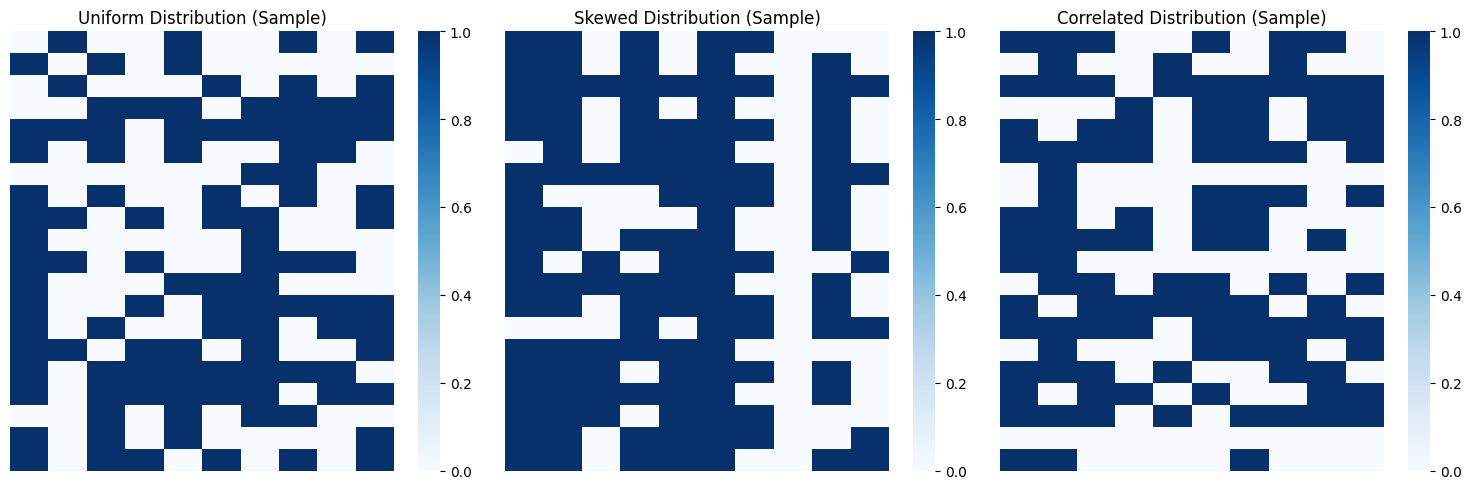

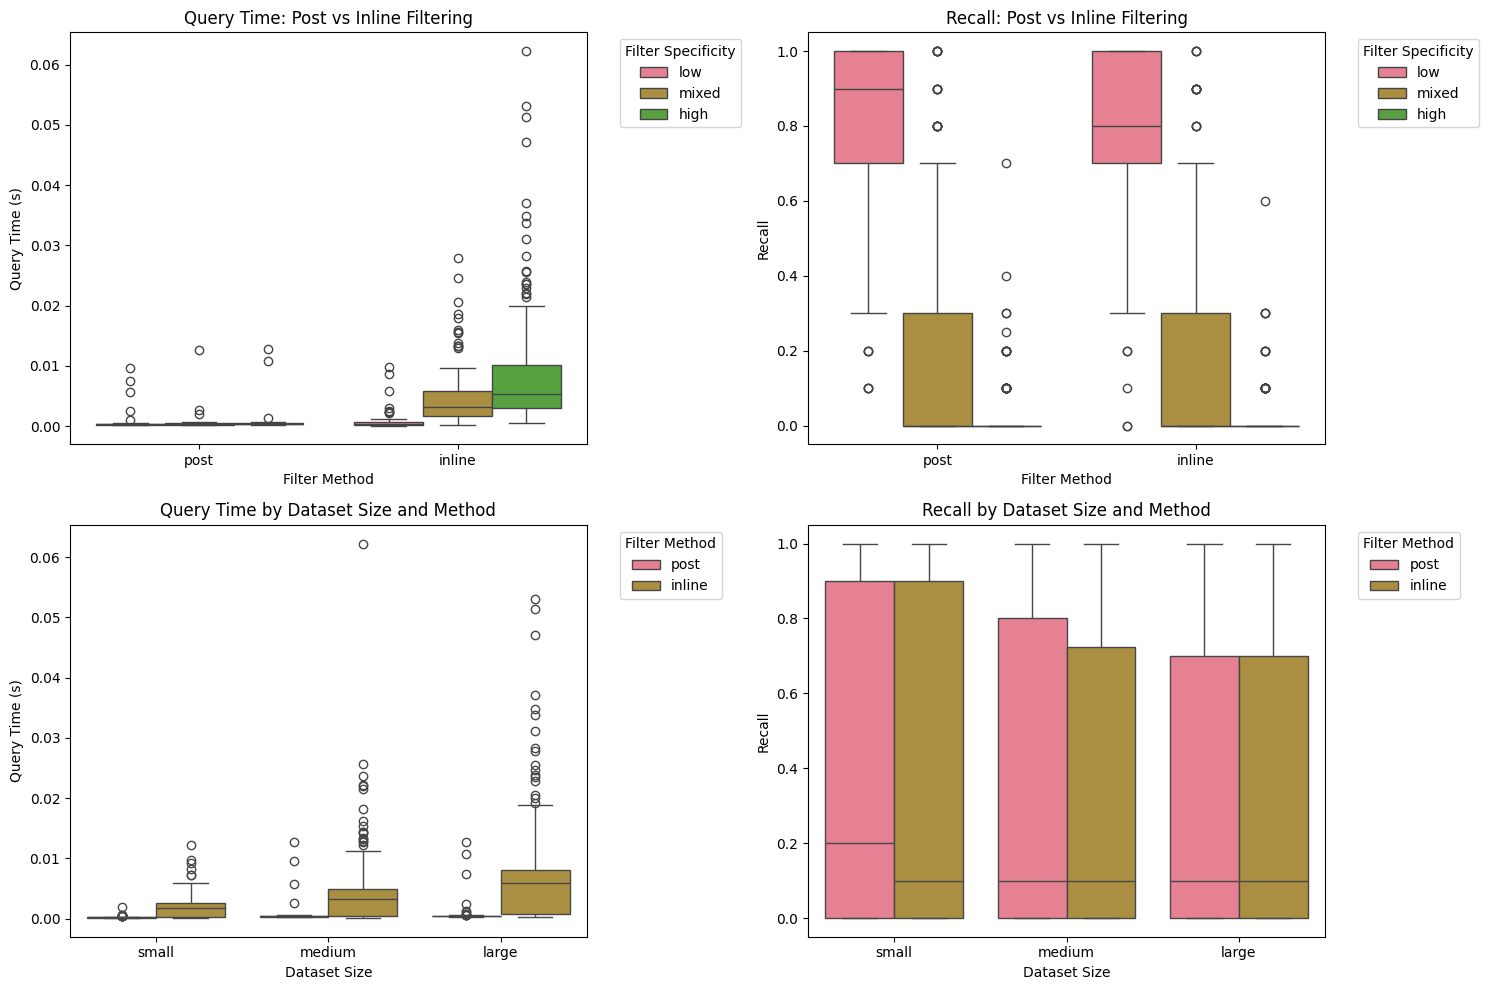

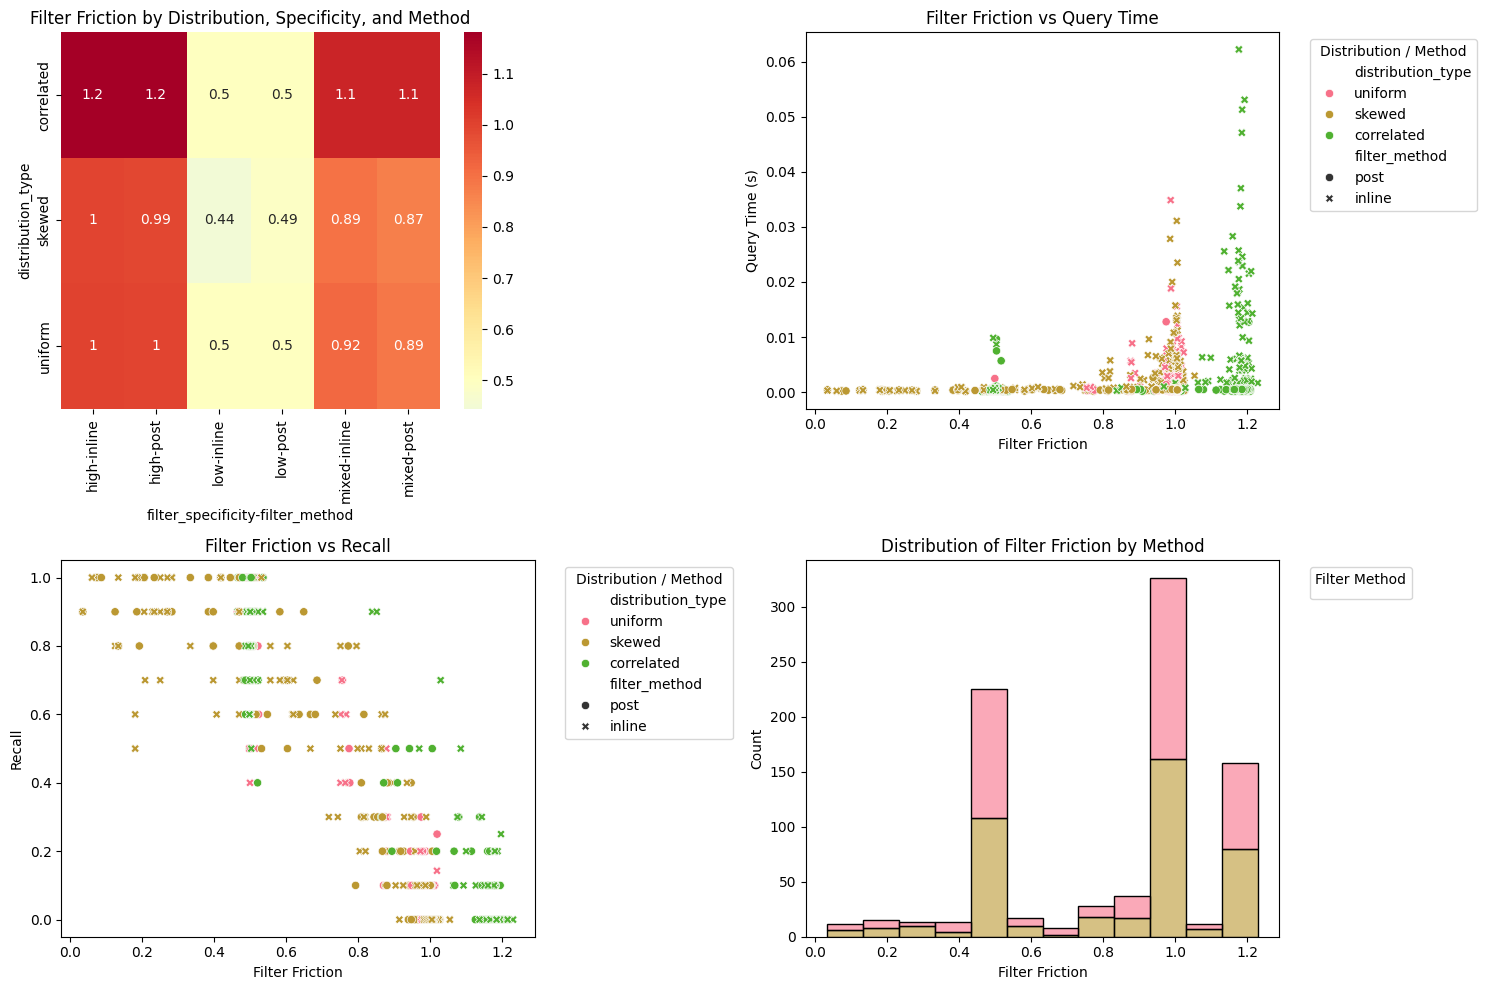

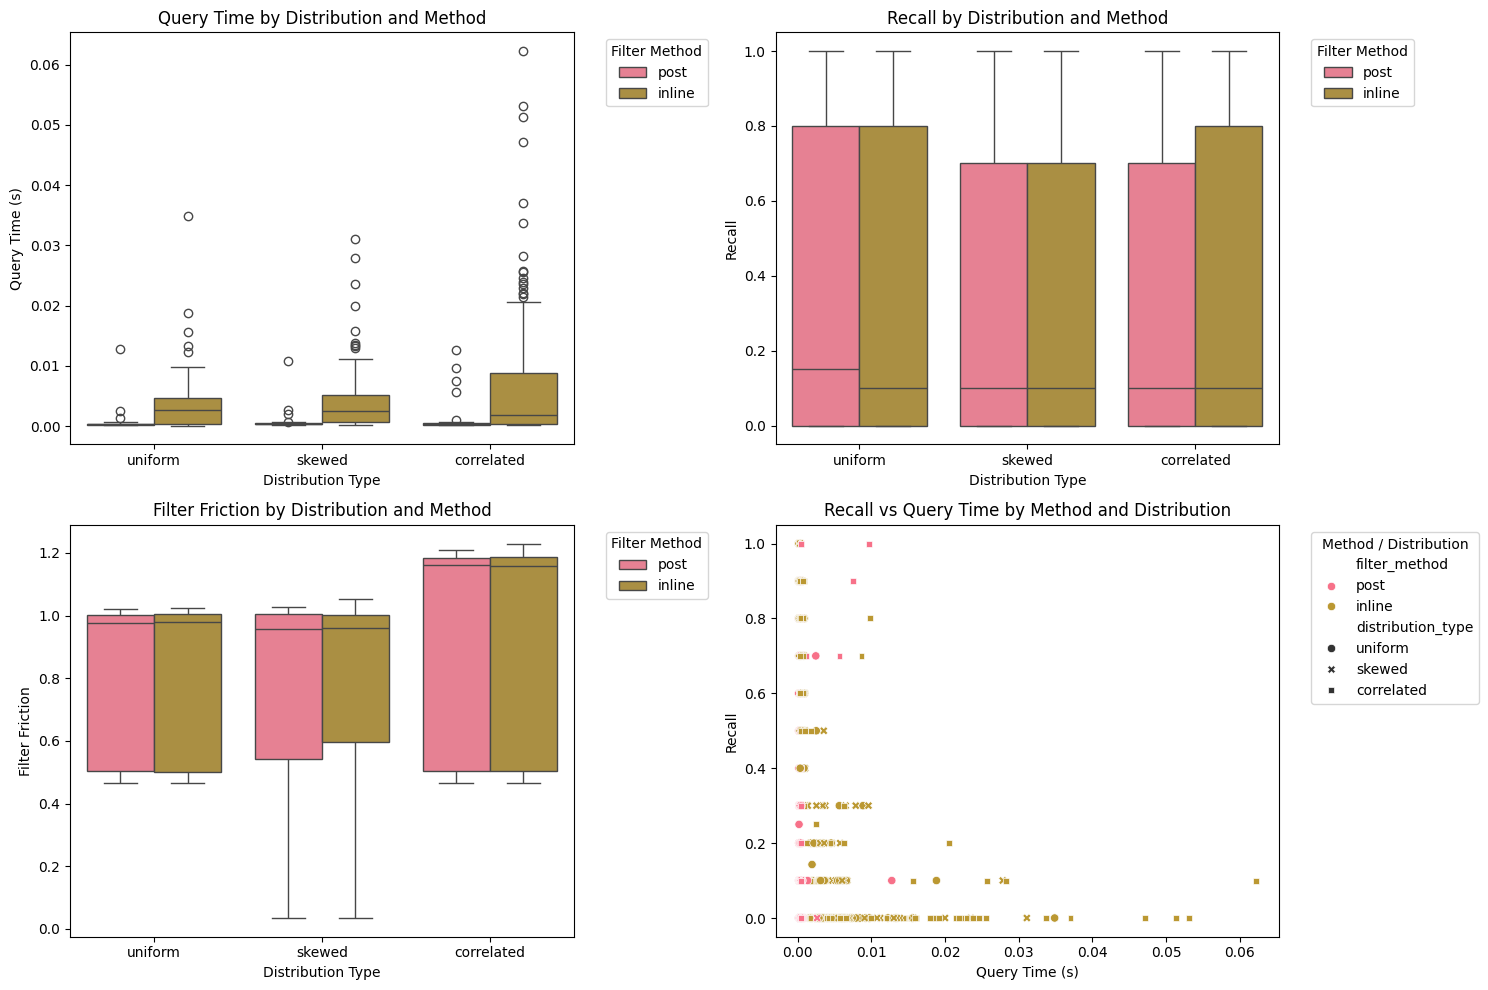

In [34]:
post_filtering_results = final_results[final_results['filter_method'] == 'post']
inline_filtering_results = final_results[final_results['filter_method'] == 'inline']

post_filtering_results.to_csv('evaluation_results_post_filtering.csv', index=False)
inline_filtering_results.to_csv('evaluation_results_inline_filtering.csv', index=False)

print("Results saved to 'evaluation_results_post_filtering.csv' and 'evaluation_results_inline_filtering.csv'")


# Distribution Analysis (Sample Attributes)
plt.figure(figsize=(15, 5))
for idx, dist in enumerate(['uniform', 'skewed', 'correlated']):
    plt.subplot(1, 3, idx+1)
    sns.heatmap(
        datasets['small'][dist]['attributes'][:20, :],
        cmap='Blues',
        xticklabels=False,
        yticklabels=False
    )
    plt.title(f'{dist.capitalize()} Distribution (Sample)')
plt.tight_layout()
plt.show()


# Query Time Comparison
plt.figure(figsize=(15, 10))

# Query time by distribution and method
plt.subplot(2, 2, 1)
sns.boxplot(x='filter_method', y='query_time', hue='filter_specificity', data=final_results)
plt.title('Query Time: Post vs Inline Filtering')
plt.xlabel('Filter Method')
plt.ylabel('Query Time (s)')
plt.legend(title='Filter Specificity', bbox_to_anchor=(1.05, 1), loc='upper left')

# Recall Comparison
plt.subplot(2, 2, 2)
sns.boxplot(x='filter_method', y='recall', hue='filter_specificity', data=final_results)
plt.title('Recall: Post vs Inline Filtering')
plt.xlabel('Filter Method')
plt.ylabel('Recall')
plt.legend(title='Filter Specificity', bbox_to_anchor=(1.05, 1), loc='upper left')

# Query Time by Dataset Size and Method
plt.subplot(2, 2, 3)
sns.boxplot(x='dataset_size', y='query_time', hue='filter_method', data=final_results)
plt.title('Query Time by Dataset Size and Method')
plt.xlabel('Dataset Size')
plt.ylabel('Query Time (s)')
plt.legend(title='Filter Method', bbox_to_anchor=(1.05, 1), loc='upper left')

# Recall by Dataset Size and Method
plt.subplot(2, 2, 4)
sns.boxplot(x='dataset_size', y='recall', hue='filter_method', data=final_results)
plt.title('Recall by Dataset Size and Method')
plt.xlabel('Dataset Size')
plt.ylabel('Recall')
plt.legend(title='Filter Method', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Filter Friction Analysis
plt.figure(figsize=(15, 10))

# Filter friction by distribution and specificity
plt.subplot(2, 2, 1)
friction_pivot = final_results.pivot_table(
    values='filter_friction',
    index='distribution_type',
    columns=['filter_specificity', 'filter_method'],
    aggfunc='mean'
)
sns.heatmap(friction_pivot, annot=True, cmap='RdYlBu_r', center=0.5)
plt.title('Filter Friction by Distribution, Specificity, and Method')

# Filter friction vs Query Time
plt.subplot(2, 2, 2)
sns.scatterplot(
    data=final_results,
    x='filter_friction',
    y='query_time',
    hue='distribution_type',
    style='filter_method'
)
plt.title('Filter Friction vs Query Time')
plt.xlabel('Filter Friction')
plt.ylabel('Query Time (s)')
plt.legend(title='Distribution / Method', bbox_to_anchor=(1.05, 1), loc='upper left')

# Filter friction vs Recall
plt.subplot(2, 2, 3)
sns.scatterplot(
    data=final_results,
    x='filter_friction',
    y='recall',
    hue='distribution_type',
    style='filter_method'
)
plt.title('Filter Friction vs Recall')
plt.xlabel('Filter Friction')
plt.ylabel('Recall')
plt.legend(title='Distribution / Method', bbox_to_anchor=(1.05, 1), loc='upper left')

# Distribution of filter friction
plt.subplot(2, 2, 4)
sns.histplot(
    data=final_results,
    x='filter_friction',
    hue='filter_method',
    multiple="stack",
    alpha=0.6
)
plt.title('Distribution of Filter Friction by Method')
plt.xlabel('Filter Friction')
plt.ylabel('Count')
plt.legend(title='Filter Method', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# Performance by Distribution and Method
plt.figure(figsize=(15, 10))

# Query Time by Distribution and Method
plt.subplot(2, 2, 1)
sns.boxplot(x='distribution_type', y='query_time', hue='filter_method', data=final_results)
plt.title('Query Time by Distribution and Method')
plt.xlabel('Distribution Type')
plt.ylabel('Query Time (s)')
plt.legend(title='Filter Method', bbox_to_anchor=(1.05, 1), loc='upper left')

# Recall by Distribution and Method
plt.subplot(2, 2, 2)
sns.boxplot(x='distribution_type', y='recall', hue='filter_method', data=final_results)
plt.title('Recall by Distribution and Method')
plt.xlabel('Distribution Type')
plt.ylabel('Recall')
plt.legend(title='Filter Method', bbox_to_anchor=(1.05, 1), loc='upper left')

# Filter Friction by Distribution and Method
plt.subplot(2, 2, 3)
sns.boxplot(x='distribution_type', y='filter_friction', hue='filter_method', data=final_results)
plt.title('Filter Friction by Distribution and Method')
plt.xlabel('Distribution Type')
plt.ylabel('Filter Friction')
plt.legend(title='Filter Method', bbox_to_anchor=(1.05, 1), loc='upper left')

# Combined Recall vs Query Time
plt.subplot(2, 2, 4)
sns.scatterplot(
    data=final_results,
    x='query_time',
    y='recall',
    hue='filter_method',
    style='distribution_type'
)
plt.title('Recall vs Query Time by Method and Distribution')
plt.xlabel('Query Time (s)')
plt.ylabel('Recall')
plt.legend(title='Method / Distribution', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Visual Analysis of Experimental Results

### Sample Attribute Distributions

- **Uniform Distribution (Sample)**: Attributes are roughly equally distributed (checkerboard-like).
- **Skewed Distribution (Sample)**: Some attributes dominate, forming large blocks of activated cells.
- **Correlated Distribution (Sample)**: Groups of attributes co-occur, revealing clusters of activated cells.

### Filtering Methods: Query Time and Recall

- **Query Time (Post vs Inline)**: Inline filtering generally incurs higher latency, especially with high specificity. Post-filtering stays low for most queries.
- **Recall (Post vs Inline)**: Post-filtering tends to yield higher recall, particularly under low or mixed specificity.

### Dataset Size vs Query Time and Recall
- **Query Time** escalates with dataset size, reflecting increased search complexity.
- **Recall** slightly decreases for large datasets, indicating the difficulty of maintaining accuracy as data scales.

### Filter Friction Insights

- **Heatmap**: Correlated distributions and high specificity drive the highest friction scores.
- **Friction vs Query Time**: Elevated friction correlates with longer query times.
- **Friction vs Recall**: Higher friction generally lowers recall.


---

> **Notes to Self**  
> - Inline filtering introduces overhead but may be useful for very specific queries.  
> - Correlated attributes are challenging for recall and speed due to high friction.  
> - Larger datasets degrade recall; consider parallel approaches or index parameter tuning.  
> - Future work: I have to investigate dynamic parameter selection for inline filtering

## 8. Summary Statistics

In [35]:
print("\nOverall Performance:")
print("==================")
metrics = ['query_time', 'recall', 'filter_friction']
for metric in metrics:
    print(f"{metric}:")
    print(f"  Mean: {final_results[metric].mean():.4f}")
    print(f"  Std:  {final_results[metric].std():.4f}")
    print(f"  Min:  {final_results[metric].min():.4f}")
    print(f"  Max:  {final_results[metric].max():.4f}")

# Performance by Distribution
print("\nPerformance by Distribution:")
dist_stats = final_results.groupby('distribution_type')[metrics].mean()
print(dist_stats)

# Performance by Filter Specificity
print("\nPerformance by Filter Specificity:")
spec_stats = final_results.groupby('filter_specificity')[metrics].mean()
print(spec_stats)

# Performance by Dataset Size
print("\nPerformance by Dataset Size:")
size_stats = final_results.groupby('dataset_size')[metrics].mean()
print(size_stats)

# Performance by Filter Method
print("\nPerformance by Filter Method:")
method_stats = final_results.groupby('filter_method')[metrics].mean()
print(method_stats)

print("Key Findings:")
print("============")

# Distribution Impact
avg_times = final_results.groupby('distribution_type')['query_time'].mean()
fastest_dist = avg_times.idxmin()
slowest_dist = avg_times.idxmax()
performance_diff = (avg_times[slowest_dist]/avg_times[fastest_dist]-1)*100

print("\n1. Distribution Impact:")
print(f"   - Fastest queries: {fastest_dist} distribution")
print(f"   - Slowest queries: {slowest_dist} distribution")
print(f"   - Performance difference: {performance_diff:.1f}%")

# Recall Analysis
recall_by_method = final_results.groupby('filter_method')['recall'].mean()
print("\n2. Recall Impact by Filtering Method:")
for method, recall in recall_by_method.items():
    print(f"   - {method.capitalize()} Filtering: {recall:.3f}")

recall_by_spec_method = final_results.groupby(['filter_specificity', 'filter_method'])['recall'].mean()
print("\n   - Recall by Specificity and Method:")
print(recall_by_spec_method)

# Scalability Analysis
scale_impact = final_results.groupby('dataset_size')['query_time'].mean()
scaling_factor = scale_impact['large'] / scale_impact['small']

print("\n3. Scalability:")
print(f"   - Performance degradation from small to large: {scaling_factor:.2f}x")
print(f"   - Average query times:")
for size in scale_impact.index:
    print(f"     * {size}: {scale_impact[size]*1000:.2f}ms")

# Filter Friction Impact
friction_impact = final_results.groupby(['filter_method', 'distribution_type'])['filter_friction'].mean()
print("\n4. Filter Friction Impact:")
print(friction_impact)


Overall Performance:
query_time:
  Mean: 0.0026
  Std:  0.0059
  Min:  0.0001
  Max:  0.0622
recall:
  Mean: 0.3433
  Std:  0.3946
  Min:  0.0000
  Max:  1.0000
filter_friction:
  Mean: 0.8334
  Std:  0.2947
  Min:  0.0345
  Max:  1.2299

Performance by Distribution:
                   query_time    recall  filter_friction
distribution_type                                       
correlated           0.003867  0.340451         0.919132
skewed               0.002204  0.325347         0.780923
uniform              0.001856  0.364211         0.800240

Performance by Filter Specificity:
                    query_time    recall  filter_friction
filter_specificity                                       
high                  0.004865  0.029340         1.058194
low                   0.000549  0.801042         0.488284
mixed                 0.002513  0.199628         0.953817

Performance by Dataset Size:
              query_time    recall  filter_friction
dataset_size                          

In [36]:
parameter_grid = {
    'ef_construction': [100, 200, 300],  # Higher values for better index quality
    'M': [8, 16, 32],                    # Trade-off between recall and memory
    'initial_ef': [50, 100, 150],        # Starting ef for searches
    'max_ef': [200, 400, 800]            # Maximum ef during inline filtering
}


In [37]:
import itertools

def run_evaluation_with_parameters(datasets, parameter_grid, n_queries=100):
    import itertools
    import pandas as pd

    all_results = []

    # Generate all combinations of parameters
    param_combinations = list(itertools.product(
        parameter_grid['ef_construction'],
        parameter_grid['M'],
        parameter_grid['initial_ef'],
        parameter_grid['max_ef']
    ))

    print("Starting parameter evaluation for inline filtering...")

    for idx, (ef_construction, M, initial_ef, max_ef) in enumerate(param_combinations, 1):
        print(f"\nEvaluating Parameter Set {idx}/{len(param_combinations)}:")
        print(f"  - ef_construction: {ef_construction}")
        print(f"  - M: {M}")
        print(f"  - initial_ef: {initial_ef}")
        print(f"  - max_ef: {max_ef}")

        for size, size_datasets in datasets.items():
            for dist, data in size_datasets.items():
                print(f"    - Dataset: {size}, Distribution: {dist}")

                # Initialize EvaluationEngine with current parameters
                evaluator = EvaluationEngine(
                    vectors=data['vectors'],
                    attributes=data['attributes'],
                    k=10,
                    initial_ef=initial_ef,
                    max_ef=max_ef
                )

                # Build index with current ef_construction and M
                evaluator.build_index(ef_construction=ef_construction, M=M)

                # Generate queries (assuming QueryWorkloadGenerator is defined)
                query_gen = QueryWorkloadGenerator(data['generator'])
                query_vectors, query_filters = query_gen.generate_queries(
                    n_queries // 3,  # Divide queries across specificities
                    filter_specificity='low'
                )
                qv_low, qf_low = query_vectors, query_filters

                query_vectors, query_filters = query_gen.generate_queries(
                    n_queries // 3,
                    filter_specificity='mixed'
                )
                qv_mixed, qf_mixed = query_vectors, query_filters

                query_vectors, query_filters = query_gen.generate_queries(
                    n_queries // 3,
                    filter_specificity='high'
                )
                qv_high, qf_high = query_vectors, query_filters

                # Concatenate all queries
                all_qv = np.concatenate([qv_low, qv_mixed, qv_high])
                all_qf = qf_low + qf_mixed + qf_high

                # Run evaluation with inline filtering
                metrics, detailed_results = evaluator.run_evaluation(
                    all_qv, all_qf, method='inline'
                )

                # Append parameter settings to results
                for result in detailed_results:
                    result.update({
                        'ef_construction': ef_construction,
                        'M': M,
                        'initial_ef': initial_ef,
                        'max_ef': max_ef,
                        'dataset_size': size,
                        'distribution_type': dist
                    })

                # Collect results
                all_results.extend(detailed_results)

    # Convert to DataFrame
    final_results = pd.DataFrame(all_results)

    return final_results

In [38]:
parameter_evaluation_results = run_evaluation_with_parameters(
    datasets=datasets,
    parameter_grid=parameter_grid,
    n_queries=100
)

# Save the results to a CSV file for further analysis
parameter_evaluation_results.to_csv('evaluation_results_inline_filtering_parameters.csv', index=False)

print("\nParameter evaluation completed. Results saved to 'evaluation_results_inline_filtering_parameters.csv'.")

Starting parameter evaluation for inline filtering...

Evaluating Parameter Set 1/81:
  - ef_construction: 100
  - M: 8
  - initial_ef: 50
  - max_ef: 200
    - Dataset: small, Distribution: uniform
    - Dataset: small, Distribution: skewed
    - Dataset: small, Distribution: correlated
    - Dataset: medium, Distribution: uniform
    - Dataset: medium, Distribution: skewed
    - Dataset: medium, Distribution: correlated
    - Dataset: large, Distribution: uniform
    - Dataset: large, Distribution: skewed
    - Dataset: large, Distribution: correlated

Evaluating Parameter Set 2/81:
  - ef_construction: 100
  - M: 8
  - initial_ef: 50
  - max_ef: 400
    - Dataset: small, Distribution: uniform
    - Dataset: small, Distribution: skewed
    - Dataset: small, Distribution: correlated
    - Dataset: medium, Distribution: uniform
    - Dataset: medium, Distribution: skewed
    - Dataset: medium, Distribution: correlated
    - Dataset: large, Distribution: uniform
    - Dataset: large, Di

In [39]:
# Load the parameter evaluation results
param_results = pd.read_csv('evaluation_results_inline_filtering_parameters.csv')

# Display the first few rows
print(param_results.head())


   query_time  recall  filter_friction filter_specificity filter_method  \
0    0.000263     0.9            0.503                low        inline   
1    0.000227     0.9            0.521                low        inline   
2    0.000213     1.0            0.489                low        inline   
3    0.000194     0.7            0.503                low        inline   
4    0.010416     0.8            0.507                low        inline   

   ef_construction  M  initial_ef  max_ef dataset_size distribution_type  
0              100  8          50     200        small           uniform  
1              100  8          50     200        small           uniform  
2              100  8          50     200        small           uniform  
3              100  8          50     200        small           uniform  
4              100  8          50     200        small           uniform  


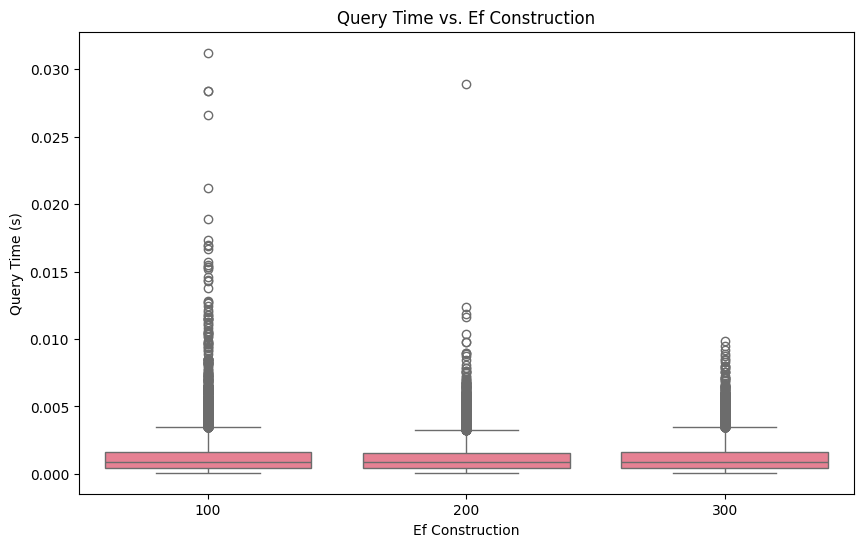

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='ef_construction', y='query_time', data=param_results)
plt.title('Query Time vs. Ef Construction')
plt.xlabel('Ef Construction')
plt.ylabel('Query Time (s)')
plt.show()


## Query Time vs. Ef Construction

- **Observation**: Each boxplot represents a distinct `ef_construction` setting (100, 200, 300).  
- **Consistency**: Median query times remain relatively close across all three settings, indicating that within this range, `ef_construction` has only a modest effect on query latency.  
- **Outliers**: A small subset of queries exhibit higher than average query times (outliers above 0.01s). These spikes due to filter specificity, attribute distribution, or computational overhead in particular scenarios.  
- **Implication**: While increasing `ef_construction` can theoretically improve index quality, the benefit for query time (in this parameter range) appears marginal.


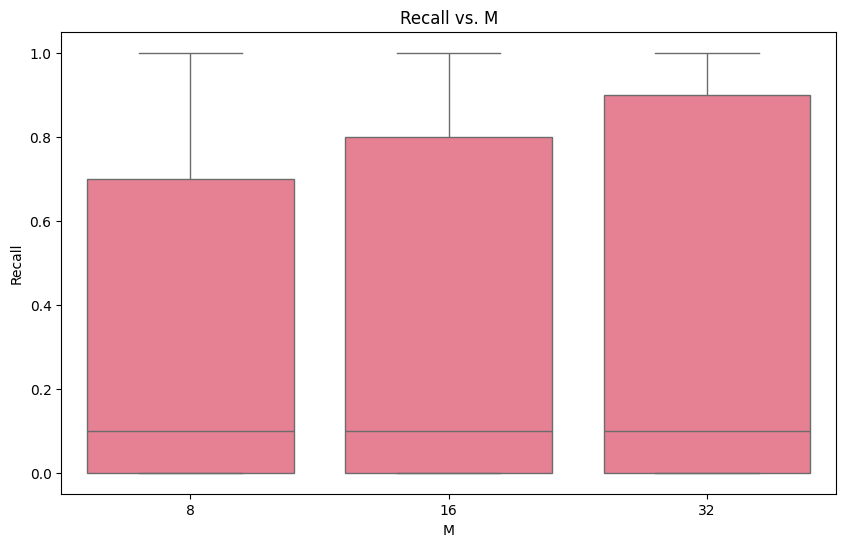

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='M', y='recall', data=param_results)
plt.title('Recall vs. M')
plt.xlabel('M')
plt.ylabel('Recall')
plt.show()


## Recall vs. M

- **Higher M → Better Recall**: As `M` increases from 8 to 32, the recall distribution shifts upward, indicating richer graph connectivity.
- **Variability**: Lower `M` settings show wider recall spread, reflecting reduced accuracy for certain queries.
- **Conclusion**: Increasing `M` can significantly enhance recall, but at the cost of larger index size and possibly increased build time.

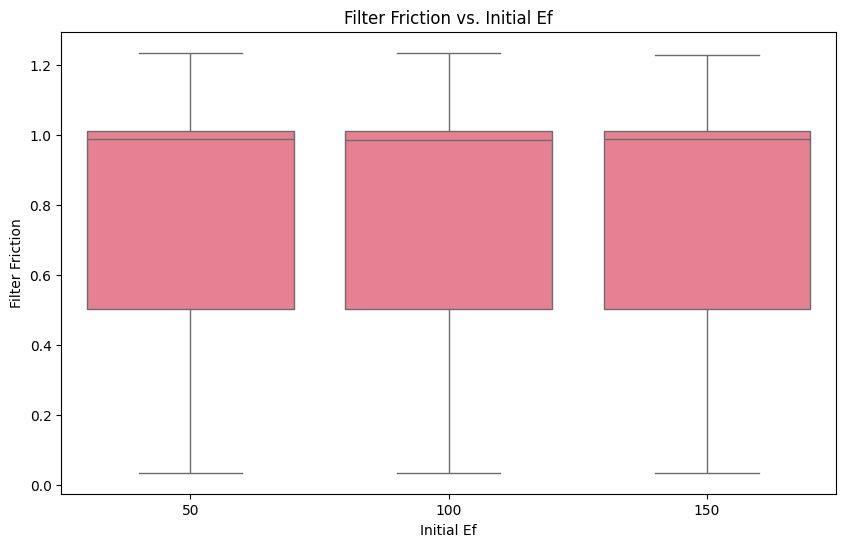

In [42]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='initial_ef', y='filter_friction', data=param_results)
plt.title('Filter Friction vs. Initial Ef')
plt.xlabel('Initial Ef')
plt.ylabel('Filter Friction')
plt.show()


## Filter Friction vs. Initial Ef


- **no Variation**: Across `initial_ef` values (50, 100, 150), median filter friction remains similar.
- **Implication**: Adjusting `initial_ef` in this range has limited direct impact on filter friction scores.


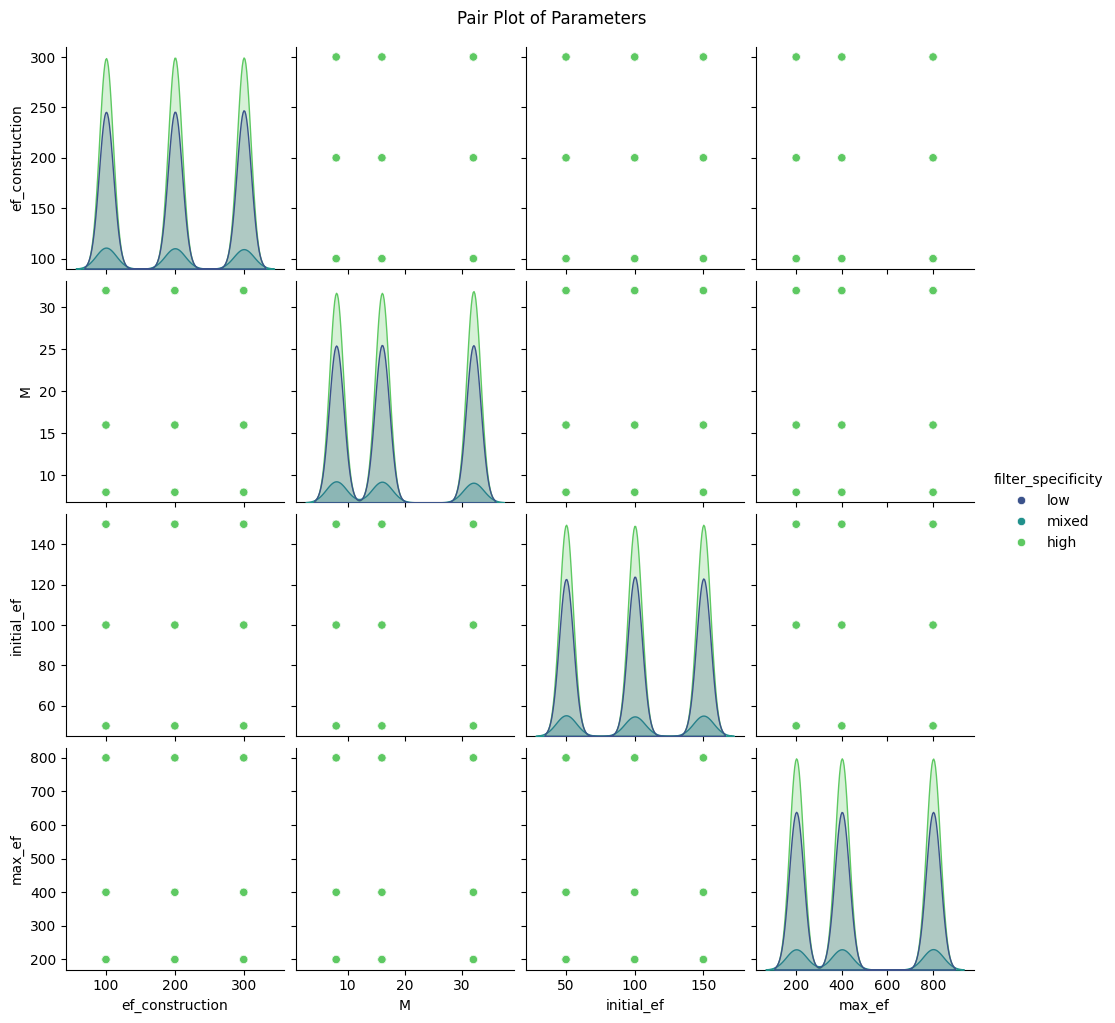

In [43]:
# Pair plot of key metrics against parameters
sns.pairplot(param_results, vars=['ef_construction', 'M', 'initial_ef', 'max_ef'],
             hue='filter_specificity', palette='viridis')
plt.suptitle('Pair Plot of Parameters', y=1.02)
plt.show()


## Pair Plot of Parameters


- **Discrete Settings**: Each parameter (`ef_construction`, `M`, `initial_ef`, `max_ef`) is sampled from a small set of values (e.g., 100, 200, 300 for `ef_construction`), producing distinct clusters rather than continuous trends.
- **KDE Diagonals**: On the diagonal, kernel density plots reveal clear, separate peaks at each discrete value—indicating no overlap between parameter settings.
- **Filter Specificity**: Low (blue), mixed (green), and high (teal) specificity levels appear uniformly distributed across all parameter choices, ensuring balanced coverage.
- **No Direct Parameter Interactions**: Off-diagonal subplots do not exhibit strong correlations because each parameter is chosen independently; performance variations must be inferred from downstream metrics (e.g., query time, recall).

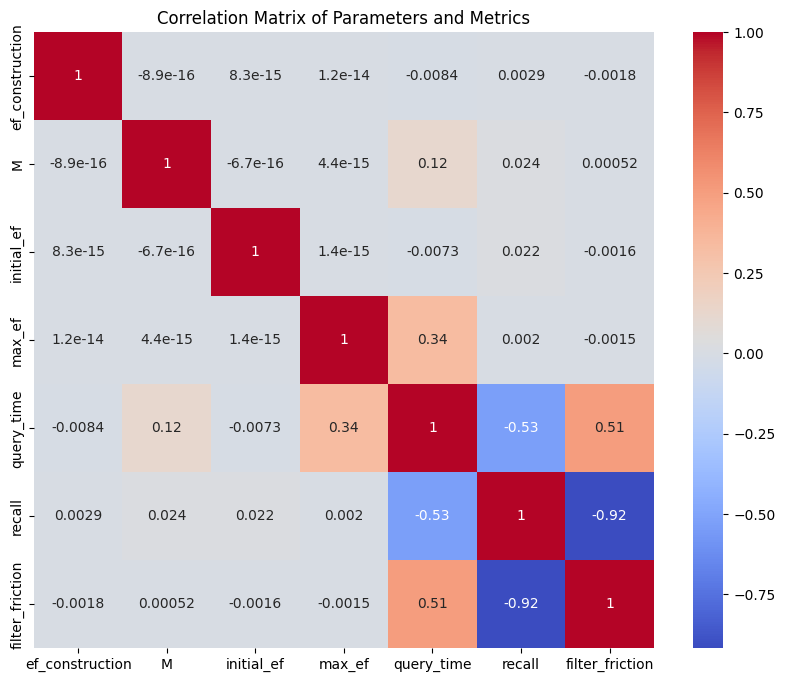

In [44]:
# Correlation matrix
correlation_matrix = param_results[['ef_construction', 'M', 'initial_ef', 'max_ef', 'query_time', 'recall', 'filter_friction']].corr()

# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Parameters and Metrics')
plt.show()

## Correlation Matrix of Parameters and Metrics

- **Parameter Independence**: The HNSW parameters (`ef_construction`, `M`, `initial_ef`, `max_ef`) have near-zero mutual correlations, indicating they were sampled independently.
- **Query Time vs. Filter Friction**: A positive correlation (`0.51`) suggests that higher friction translates to longer query times.
- **Recall vs. Query Time**: The negative correlation (`-0.53`) reveals that queries taking more time often yield lower recall.
- **Recall vs. Filter Friction**: Strongly negative (`-0.92`), confirming that complex/high-friction filters strongly diminish recall.
- **Inference**: Tuning parameters alone (within tested ranges) has minimal direct impact on friction or recall; major shifts in performance stem from filter conditions (specificity, distribution) rather than from these particular HNSW settings.
